<a href="https://colab.research.google.com/github/RodrigoOBC/Notebooks_RedesNeurais/blob/main/Identificador_esta_usando_mascara_com_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import re
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

2021-10-03 22:54:30.132004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
IMAGE_SIZE = [224, 224]
EPOCHS = 50

In [ ]:
GCS_PATH = "../input/face-mask-detection/Dataset"

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "*/*"))])
CLASS_NAMES

2021-10-03 22:54:35.057942: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-03 22:54:35.061169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-03 22:54:35.102972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 22:54:35.103637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-03 22:54:35.103705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-03 22:54:35.129155: I tensorflow/stream_executor/platform/def

array(['without_mask', 'mask_weared_incorrect', 'with_mask'], dtype='<U21')

In [ ]:
files_count = []
for i,f in enumerate(CLASS_NAMES):
    folder_path = os.path.join(GCS_PATH, f)
    for path in os.listdir(os.path.join(folder_path)):
        files_count.append(['{}/{}'.format(folder_path,path), f, i])
images_dataset = pd.DataFrame(files_count, columns=['filepath', 'class_name', 'label'])
images_dataset.head()

,filepath,class_name,label
0,../input/face-mask-detection/Dataset/without_m...,without_mask,0
1,../input/face-mask-detection/Dataset/without_m...,without_mask,0
2,../input/face-mask-detection/Dataset/without_m...,without_mask,0
3,../input/face-mask-detection/Dataset/without_m...,without_mask,0
4,../input/face-mask-detection/Dataset/without_m...,without_mask,0


In [ ]:
images_dataset.class_name.value_counts()

without_mask             2994
with_mask                2994
mask_weared_incorrect    2994
Name: class_name, dtype: int64

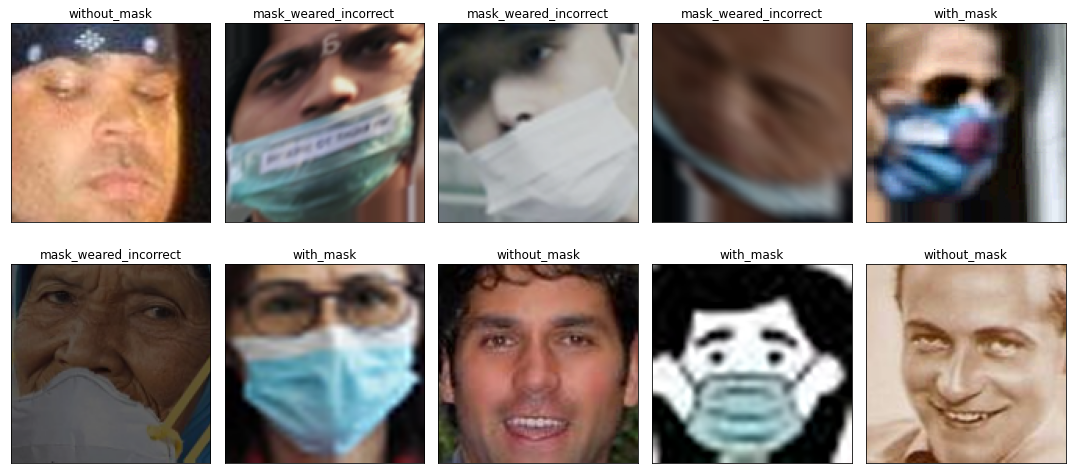

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,images_dataset.shape[0]-1)
    ax.imshow(plt.imread(images_dataset.filepath[ponteiro]))
    ax.set_title(images_dataset.class_name[ponteiro])
plt.tight_layout()
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=images_dataset,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=images_dataset,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 7186 validated image filenames belonging to 3 classes.
Found 1796 validated image filenames belonging to 3 classes.


In [ ]:
def build_model():
    base_VGG19 = VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(3, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
    return model

In [ ]:

VGG19_rede = build_model()
VGG19_rede.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
stop = EarlyStopping(monitor='loss', mode='min', patience=15, restore_best_weights=True)
opt = Adam(learning_rate=0.0001)
VGG19_rede.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
history = VGG19_rede.fit(train_images, epochs=EPOCHS,validation_data=val_images)

2021-10-03 22:54:48.974768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-03 22:54:48.978743: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000150000 Hz


Epoch 1/50


2021-10-03 22:54:50.075608: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-03 22:54:50.866093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-03 22:54:50.893415: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


225/225 [==============================] - 87s 339ms/step - loss: 0.4354 - accuracy: 0.8271 - val_loss: 0.0456 - val_accuracy: 0.9866
Epoch 2/50
225/225 [==============================] - 61s 270ms/step - loss: 0.0711 - accuracy: 0.9793 - val_loss: 0.0854 - val_accuracy: 0.9749
Epoch 3/50
225/225 [==============================] - 61s 271ms/step - loss: 0.0724 - accuracy: 0.9803 - val_loss: 0.0292 - val_accuracy: 0.9894
Epoch 4/50
225/225 [==============================] - 61s 271ms/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0813 - val_accuracy: 0.9694
Epoch 5/50
225/225 [==============================] - 61s 271ms/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 0.0516 - val_accuracy: 0.9827
Epoch 6/50
225/225 [==============================] - 61s 271ms/step - loss: 0.0252 - accuracy: 0.9924 - val_loss: 0.0485 - val_accuracy: 0.9878
Epoch 7/50
225/225 [==============================] - 61s 272ms/step - loss: 0.0368 - accuracy: 0.9870 - val_loss: 0.1585 - val_accuracy: 0.9

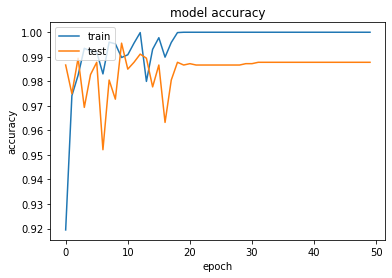

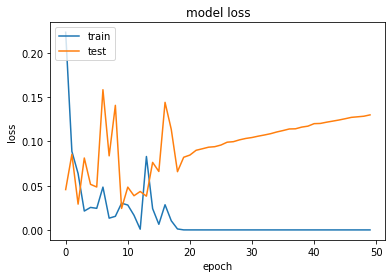

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
x  = images_dataset['filepath']
y = images_dataset['class_name']


X_train, X_test, y_train, y_test = train_test_split(x,y , shuffle=True)

In [ ]:
test_dict = {'filepath':X_test,'class_name':y_test}

In [ ]:
df_test = pd.DataFrame(data=test_dict)

In [ ]:
df_test.head()

,filepath,class_name
4674,../input/face-mask-detection/Dataset/mask_wear...,mask_weared_incorrect
5439,../input/face-mask-detection/Dataset/mask_wear...,mask_weared_incorrect
3258,../input/face-mask-detection/Dataset/mask_wear...,mask_weared_incorrect
2382,../input/face-mask-detection/Dataset/without_m...,without_mask
6663,../input/face-mask-detection/Dataset/with_mask...,with_mask


In [ ]:

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 2246 validated image filenames belonging to 3 classes.


In [ ]:
pred = VGG19_rede.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_test.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9977738201246661


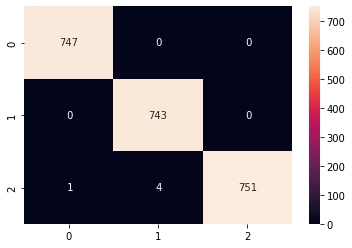

In [ ]:

print(f"Accuracy Score: {accuracy_score(pred_df['class_name'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['class_name'],pred_df['pred']), annot=True, fmt='2d');

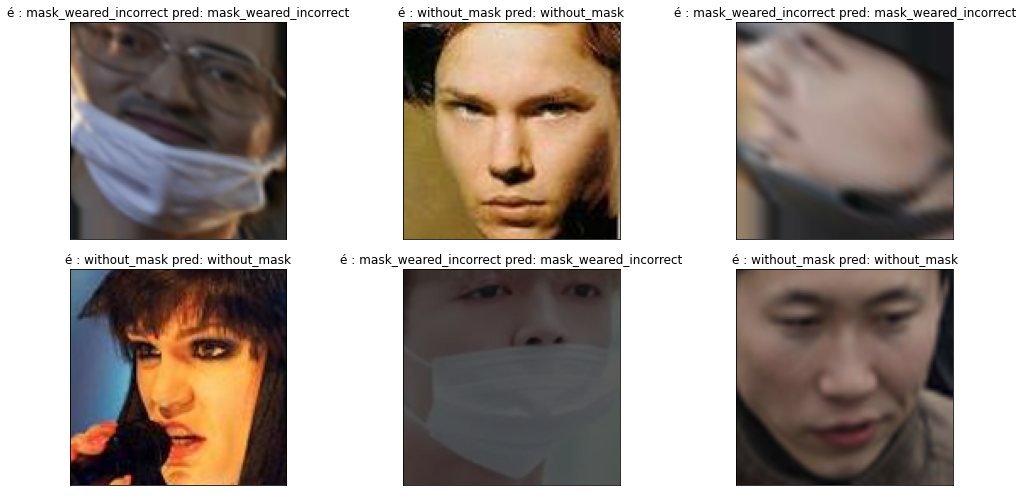

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,pred_df.shape[0]-1)
    ax.imshow(plt.imread(list(pred_df.filepath)[ponteiro]))
    ax.set_title(f'é : {list(pred_df.class_name)[ponteiro]} pred: {list(pred_df.pred)[ponteiro]}')
plt.tight_layout()
plt.show()